In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('Reddit_covid_threads.csv')
df1 = pd.read_csv('Youtube_covid_comments.csv')
df2 = pd.read_csv('Twitter_covid_tweets.csv')

In [ ]:
import re
def combine_text(df):
  text = '. '.join(df['Text'].to_list())
  text = re.sub("(\s*[\.!?:]\s*[\.!?:]*\s*)+", ". ", text)
  text = re.sub("(\s*,\s*[\.!?:,]*\s*)+", ", ", text)
  return text

In [ ]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [ ]:
def low_rank_svd(matrix, singular_count=2):
    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt

In [ ]:
def summarize(DOCUMENT):
  sentences = list(set(nltk.sent_tokenize(DOCUMENT)))

  normalize_corpus = np.vectorize(normalize_document)
  norm_sentences = normalize_corpus(sentences)

  tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
  dt_matrix = tv.fit_transform(norm_sentences)
  dt_matrix = dt_matrix.toarray()

  vocab = tv.get_feature_names_out()
  td_matrix = dt_matrix.T
  # pd.DataFrame(np.round(td_matrix, 2), index=vocab).head(10)

  num_sentences = 80
  num_topics = 8

  u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)  
  # print(u.shape, s.shape, vt.shape)
  term_topic_mat, singular_values, topic_document_mat = u, s, vt

  # remove singular values below threshold                                         
  sv_threshold = 0.5
  min_sigma_value = max(singular_values) * sv_threshold
  singular_values[singular_values < min_sigma_value] = 0

  salience_scores = np.sqrt(np.dot(np.square(singular_values),np.square(topic_document_mat)))
  top_sentence_indices = (-salience_scores).argsort()[:num_sentences]
  top_sentence_indices.sort()
  summarized_result = ' '.join(np.array(sentences)[top_sentence_indices])

  return summarized_result

In [ ]:
categories = range(20)
emotions = ['fear', 'joy', 'surprise', 'sadness']

df_all = pd.concat([df,df1,df2])
for category in categories:
  for emotion in emotions:
    print("Whole Summary of Topic " + str(category) + " with Emotion " + str(emotion))
    text_file = open("all_" + str(category)+ "_" + str(emotion) + ".txt", "w")
    text_file.write(summarize(combine_text(df_all[(df_all['Category'] == category) & (df_all['Emotion'] == emotion)])))
    text_file.close()

Whole Summary of Topic 0 with Emotion fear
Whole Summary of Topic 0 with Emotion joy
Whole Summary of Topic 0 with Emotion surprise
Whole Summary of Topic 0 with Emotion sadness
Whole Summary of Topic 1 with Emotion fear
Whole Summary of Topic 1 with Emotion joy
Whole Summary of Topic 1 with Emotion surprise
Whole Summary of Topic 1 with Emotion sadness
Whole Summary of Topic 2 with Emotion fear
Whole Summary of Topic 2 with Emotion joy
Whole Summary of Topic 2 with Emotion surprise
Whole Summary of Topic 2 with Emotion sadness
Whole Summary of Topic 3 with Emotion fear
Whole Summary of Topic 3 with Emotion joy
Whole Summary of Topic 3 with Emotion surprise
Whole Summary of Topic 3 with Emotion sadness
Whole Summary of Topic 4 with Emotion fear
Whole Summary of Topic 4 with Emotion joy
Whole Summary of Topic 4 with Emotion surprise
Whole Summary of Topic 4 with Emotion sadness
Whole Summary of Topic 5 with Emotion fear
Whole Summary of Topic 5 with Emotion joy
Whole Summary of Topic 5 

In [ ]:
from google.colab import files

for category in categories:
  for emotion in emotions:
    files.download("all_" + str(category)+ "_" + str(emotion) + ".txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fear_count = []
surprise_count = []
joy_count = []
sadness_count = []
for category in categories:
  fear_count.append(df[(df['Category'] == category) & (df['Emotion'] == 'fear')].shape[0])
  surprise_count.append(df[(df['Category'] == category) & (df['Emotion'] == 'surprise')].shape[0])
  sadness_count.append(df[(df['Category'] == category) & (df['Emotion'] == 'sadness')].shape[0])
  joy_count.append(df[(df['Category'] == category) & (df['Emotion'] == 'joy')].shape[0])

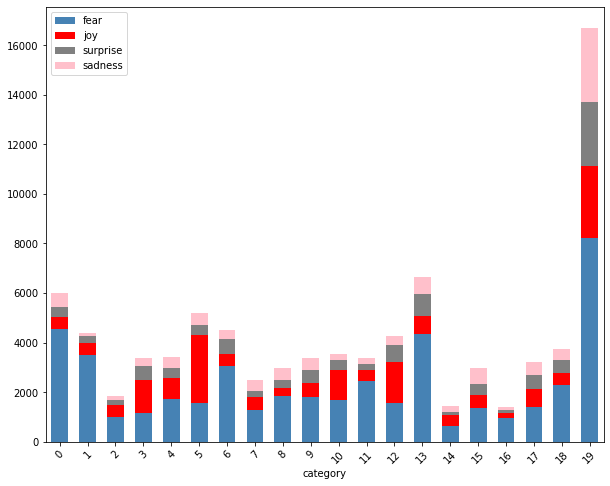

In [ ]:
# importing package
import matplotlib.pyplot as plt
import seaborn as sns

emotion_df = pd.DataFrame({'category': categories, 'fear': fear_count, 'joy': joy_count, 'surprise': surprise_count, 'sadness': sadness_count})
fig, ax = plt.subplots(figsize=(10,8))

emotion_df.set_index('category').plot(kind='bar', ax=ax, stacked=True, color=['steelblue', 'red', 'gray', 'pink'])
plt.xticks(rotation=45)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .6)